In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import imageUtils, postProcessing, DefectDetectionDataset

In [4]:
import numpy as np
import os

from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

Specify data root directory if image data exists

In [5]:
root = '/home/wei/Data/Loop_detection'

Dowload data if no image data exists. The data is available at [Google Drive](https://drive.google.com/open?id=1mpFjD40cRAkSogUoqMpbUsWJKoTdFXUy) or [Dropbox](https://www.dropbox.com/sh/ttl5u14uzqxrili/AAAa1XMxP9AVJPQ3ie7xZZVxa?dl=0). Download and extract it to the data root directory.

In [6]:
dataset = DefectDetectionDataset(data_dir=root, split='train')
dataset_test = DefectDetectionDataset(data_dir=root, split='test')

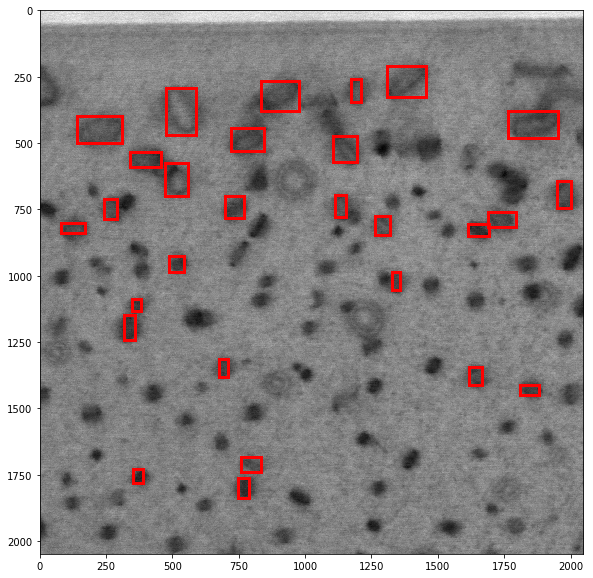

In [7]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[200]
vis_bbox(img, bbox, label, ax=ax1)
plt.show()

# Training Faster-RCNN

In case the training takes a long time, the trained model for testing is available at [HERE](https://drive.google.com/open?id=16x88tZxC2zsmIMhpUBEsWcgl9rJlNVT0). Download it and put it under ```./result/``` folder.

If train on GPU, set flag ```use_gpu``` to True; otherwise set to False

In [ ]:
use_gpu = False

In [ ]:
import numpy as np

import chainer
from chainer.datasets import ConcatenatedDataset
from chainer.datasets import TransformDataset
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger

from chainercv.datasets import voc_bbox_label_names
from chainercv.datasets import VOCBboxDataset
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms


class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = transforms.resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale
bbox_label_names = ('loop')

In [ ]:
n_itrs = 70000
n_step = 50000
np.random.seed(0)
train_data = DefectDetectionDataset.DefectDetectionDataset(split='train')
test_data = DefectDetectionDataset.DefectDetectionDataset(split='test')
faster_rcnn = FasterRCNNVGG16(n_fg_class=1, pretrained_model='imagenet')
faster_rcnn.use_preset('evaluate')
model = FasterRCNNTrainChain(faster_rcnn)
device_num = -1
if use_gpu:
    device_num = 0
    chainer.cuda.get_device_from_id(device_num).use()
    model.to_gpu()
optimizer = chainer.optimizers.MomentumSGD(lr=1e-3, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
train_data = TransformDataset(train_data, Transform(faster_rcnn))
train_iter = chainer.iterators.MultiprocessIterator(
    train_data, batch_size=1, n_processes=None, shared_mem=100000000)
test_iter = chainer.iterators.SerialIterator(
    test_data, batch_size=1, repeat=False, shuffle=False)
updater = chainer.training.updater.StandardUpdater(
    train_iter, optimizer, device=device_num)
trainer = training.Trainer(updater, (n_itrs, 'iteration'), out='result')
trainer.extend(
    extensions.snapshot_object(model.faster_rcnn, 'snapshot_model_{}.npz'.format(updater.iteration)),
    trigger=(n_itrs/10, 'iteration'))
trainer.extend(extensions.ExponentialShift('lr', 0.1),
               trigger=(n_step, 'iteration'))
log_interval = 20, 'iteration'
plot_interval = 100, 'iteration'
print_interval = 20, 'iteration'
trainer.extend(chainer.training.extensions.observe_lr(),
               trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(
    ['iteration', 'epoch', 'elapsed_time', 'lr',
     'main/loss',
     'main/roi_loc_loss',
     'main/roi_cls_loss',
     'main/rpn_loc_loss',
     'main/rpn_cls_loss',
     'validation/main/map',
     ]), trigger=print_interval)
trainer.extend(extensions.ProgressBar(update_interval=5))
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss'],
            file_name='loss.png', trigger=plot_interval
        ),
        trigger=plot_interval
    )
trainer.extend(
    DetectionVOCEvaluator(
        test_iter, model.faster_rcnn, use_07_metric=True,
        label_names=voc_bbox_label_names),
    trigger=ManualScheduleTrigger(
        [100, 500, 1000, 10000, n_step, n_itrs], 'iteration'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.run()

# Testing

In case the training takes a long time, the trained model for testing is available at [HERE](https://drive.google.com/open?id=16x88tZxC2zsmIMhpUBEsWcgl9rJlNVT0). Download it and put it under ```./result/``` folder.

If need to use CPU for testing, set ```use_gpu``` to False. Otherwise, set it to True

In [9]:
use_gpu = True

model = FasterRCNNVGG16(n_fg_class=1, pretrained_model='result/snapshot_model_70000.npz')
if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()

In [10]:
bbox_label_names = ('loop')

In [103]:
bbox, label, score = model.predict([img_0])

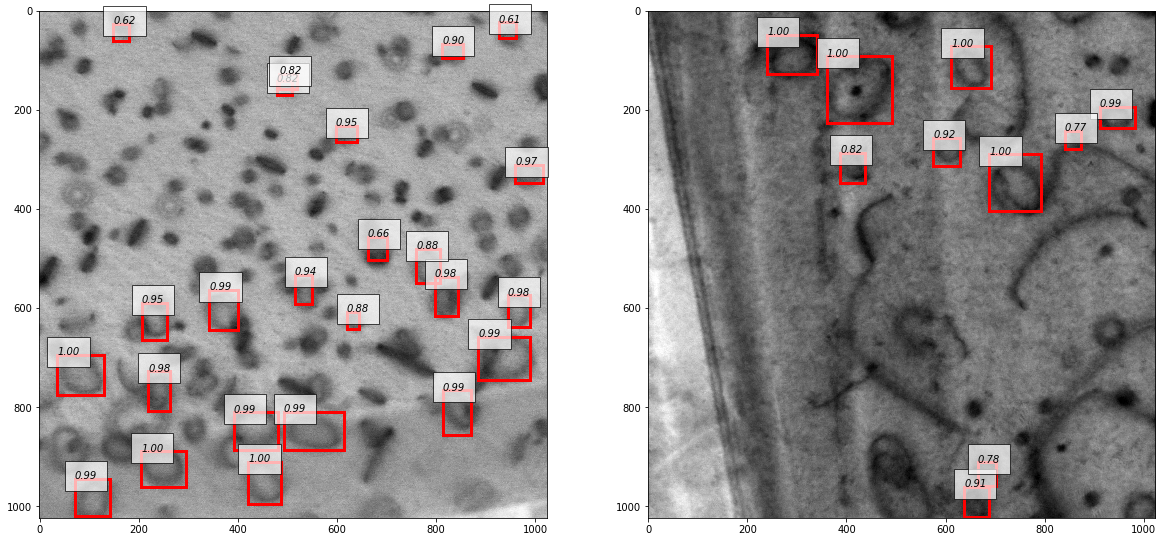

In [11]:
img_0, bbs_1, _ = dataset_test[3]
img_1, bbs_2, _ = dataset_test[14]
model.score_thresh = 0.6
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict([img_0, img_1])
# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bboxes[0], labels[0], scores[0], ax=ax1)
vis_bbox(img_1, bboxes[1], labels[1], scores[1], ax=ax2)
plt.show()

Compare with the ground truth

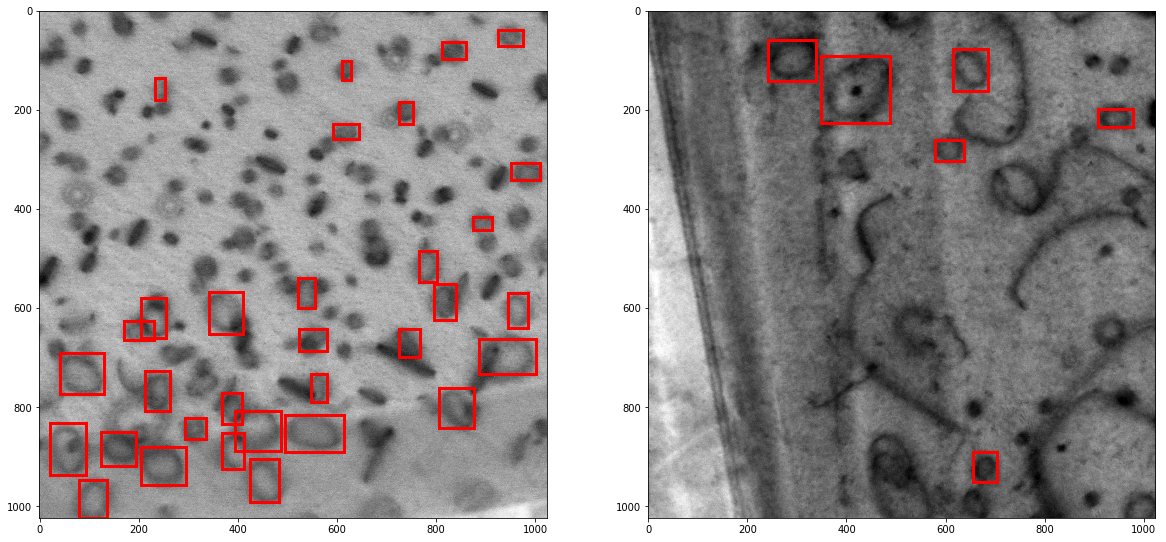

In [12]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bbs_1, ax=ax1)
vis_bbox(img_1, bbs_2, ax=ax2)
plt.show()

In [90]:
from utils import compute_score_by_centroid

In [96]:
r, p = compute_score_by_centroid(bboxes[0], bbs_1)

In [95]:
np.nonzero((diffs < tol).all(2))

(array([0, 1, 2, 4, 5, 8]), array([4, 5, 0, 2, 1, 3]))

In [ ]:
def get_dist_range(bboxes_list):
    for bboxes in bboxes_list:
        

In [104]:
r

0.59375

In [98]:
p

0.7916666666666666

# Post Processing

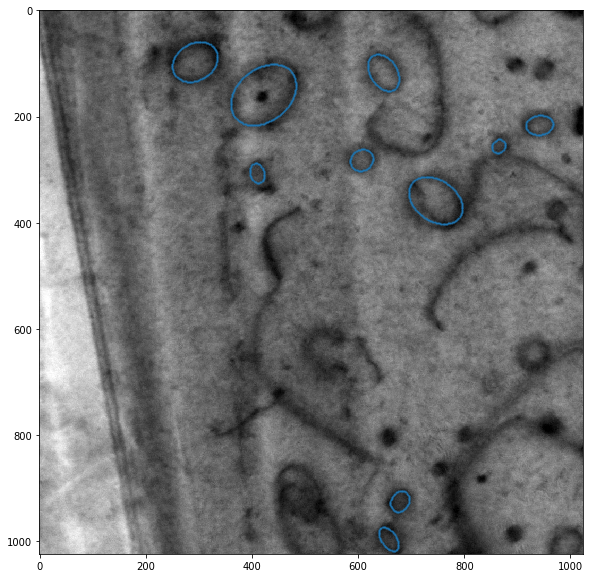

In [13]:
postProcessing.img_ellipse_fitting(img_1,bboxes[1])

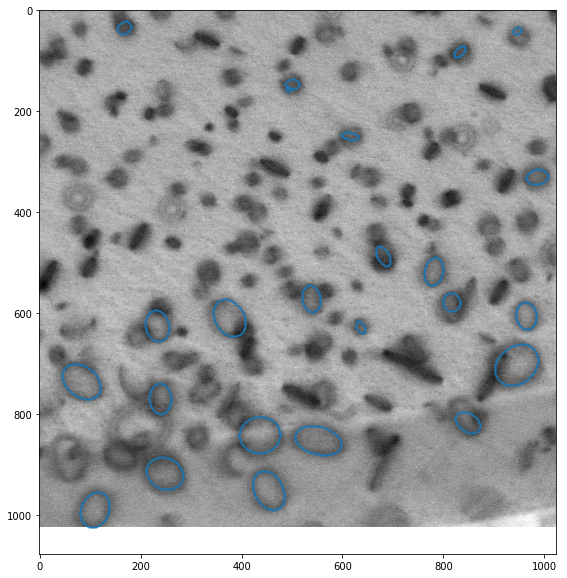

In [14]:
postProcessing.img_ellipse_fitting(img_0,bboxes[0])

# Development Tools

To crop image by the bounding boxes, use ```imageUtils.cropImage``` method

In [14]:
subimages, _ = imageUtils.cropImage(img_0, bbs_1)

To show an image, use ```imageUtils.showImage``` method

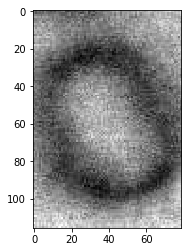

In [15]:
imageUtils.showImage(subimages[6])

To save image, use ```write_image``` method

In [ ]:
write_image(subimages[6], "./subimage6.jpg")